# Data Analysis of Credit Risk Dataset and Predictive Machine Learning Models for Creditworthiness (93% Accuracy, 89% F1 Score)

## Goals:

1. **Understand the Data**: This involves exploring the dataset to gain insights into its structure, identifying the different variables, their types, and distributions.

2. **Clean the Data**: Preprocessing and data cleaning are essential to ensure the data is suitable for analysis. This step includes handling missing values, dealing with outliers, and transforming variables as needed.

3. **Perform Statistical Analysis on the Data**: This step aims to answer the questions posed in the analysis by conducting relevant statistical tests, exploring correlations between variables, and identifying any patterns or trends that might exist.

4. **Exploratory Data Visualization**: Create visualizations to gain deeper insights into the relationships between variables, identify any data patterns, and present the findings in a clear and understandable manner.

6. **Create Data Preprocessing Function**: Develop a function that imports the dataset and performs data wrangling tasks, including handling missing values, data transformations and handle outliers. This function will return the clean dataset.

7. **Develop Models**:  Predict Credit Risk with High Accuracy and F1 Score, Precision etc.

## Import Libraries

In [18]:
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import LabelEncoder
import warnings, gc
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from yellowbrick.classifier import ClassPredictionError
from IPython.core.interactiveshell import InteractiveShell
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split

## Import Data from Kaggle into Notebook

In [19]:

# Provide the correct file path and name with the extension
data_path = "/Users/ameed/desktop/projects/credit_risk_dataset.csv"

# Read the CSV file into a DataFrame
credit_df = pd.read_csv(data_path)


## Inspect the data

In [20]:
credit_df.info()
credit_df.head()
credit_df.describe()
credit_df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

## Transforming the Data

In [21]:
# Convert loan_status to categorical
credit_df['loan_status'] = credit_df['loan_status'].astype('category')

## Data Cleaning

**Removal of missing values** 

In [22]:
credit_df.dropna(inplace=True)
credit_df.isnull().sum()
credit_df = credit_df.drop_duplicates()

In [23]:
credit_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,28501.000000,2.850100e+04,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000
mean,27.738676,6.665441e+04,4.790148,9658.533034,11.045385,0.169517,5.800498
std,6.316166,6.237603e+04,4.157462,6329.604672,3.230748,0.106410,4.042153
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.950000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


## Creating Vizualitions for Analysis

In [25]:
def plot_numerical(df):
    """Plot Distributions of numerical columns in a dataframe

    Args:
        df: Pandas dataframe
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected Pandas DataFrame Object")
    
    # Identify numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_columns = [column for column in df.columns if column not in numerical_columns]

    num_rows = math.ceil((len(numerical_columns)) / 2)
    fig, axs = plt.subplots(num_rows, 2, figsize=(16, 6*num_rows))

    # Plot histograms for numerical features
    row = 0
    for i, column in enumerate(numerical_columns):
        col = i % 2
        # Calculate bin edges using numpy.histogram
        hist, bin_edges = np.histogram(df[column], bins=20)
        xtick_positions = np.linspace(bin_edges[0], bin_edges[-1], 6)

        axs[row, col].hist(df[column], bins=bin_edges, color='blue', edgecolor='black', alpha=0.7, label=column)
        axs[row, col].set_title(f'Distribution of {column}')
        axs[row, col].set_xlabel('Value')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].grid(True)
        axs[row, col].set_xticks(xtick_positions)

        if (i + 1) % 2 == 0:
            row += 1

    # Remove the last subplot if it is empty
    if len(numerical_columns) % 2 != 0:
        axs.flatten()[-1].axis('off')

    plt.tight_layout()
    plt.show()

def plot_box(df):
    """ Makes boxplots of numerical columns in a dataframe

    Args:
        df: Pandas dataframe
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected Pandas DataFrame Object")

    # Identify numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_columns = [column for column in df.columns if column not in numerical_columns]

    num_rows = math.ceil(len(numerical_columns) / 2)
    fig, axs = plt.subplots(num_rows, 2, figsize=(16, 6*num_rows))

    # Create boxplots for numerical features
    row = 0
    for i, column in enumerate(numerical_columns):
        col = i % 2
        sns.boxplot(y=column, data=df, ax=axs[row, col],color='skyblue', width=0.4)
        axs[row, col].set_title(f'Boxplot of {column}')
        axs[row, col].set_ylabel('Values')

        if (i + 1) % 2 == 0:
            row += 1

    # Remove the last subplot if it is empty
    if len(numerical_columns) % 2 != 0:
        axs.flatten()[-1].axis('off')
    plt.tight_layout()
    plt.show()


def plot_categorical(df):
    """Plot Distributions of categorical columns in a dataframe

    Args:
        df: Pandas dataframe
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected Pandas DataFrame Object")
    
    # Identify numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_columns = [column for column in df.columns if column not in numerical_columns]

    num_rows = math.ceil((len(categorical_columns)) / 2)
    fig, axs = plt.subplots(num_rows, 2, figsize=(16, 6*num_rows))

    # Plot bar graphs for categorical features
    row = 0
    for i, column in enumerate(categorical_columns):
        col = i % 2
        sns.countplot(x=column, data=df, ax=axs[row, col], width=0.4)
        axs[row, col].set_title(f'Bar Graph of {column}')
        axs[row, col].set_xlabel(column)
        axs[row, col].set_ylabel('Count')
        axs[row, col].grid(True)
        axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)

        if (i + 1) % 2 == 0:
            row += 1
    
    # Remove the last subplot if it is empty
    if len(categorical_columns) % 2 != 0:
        axs.flatten()[-1].axis('off')

    plt.tight_layout()
    plt.show()

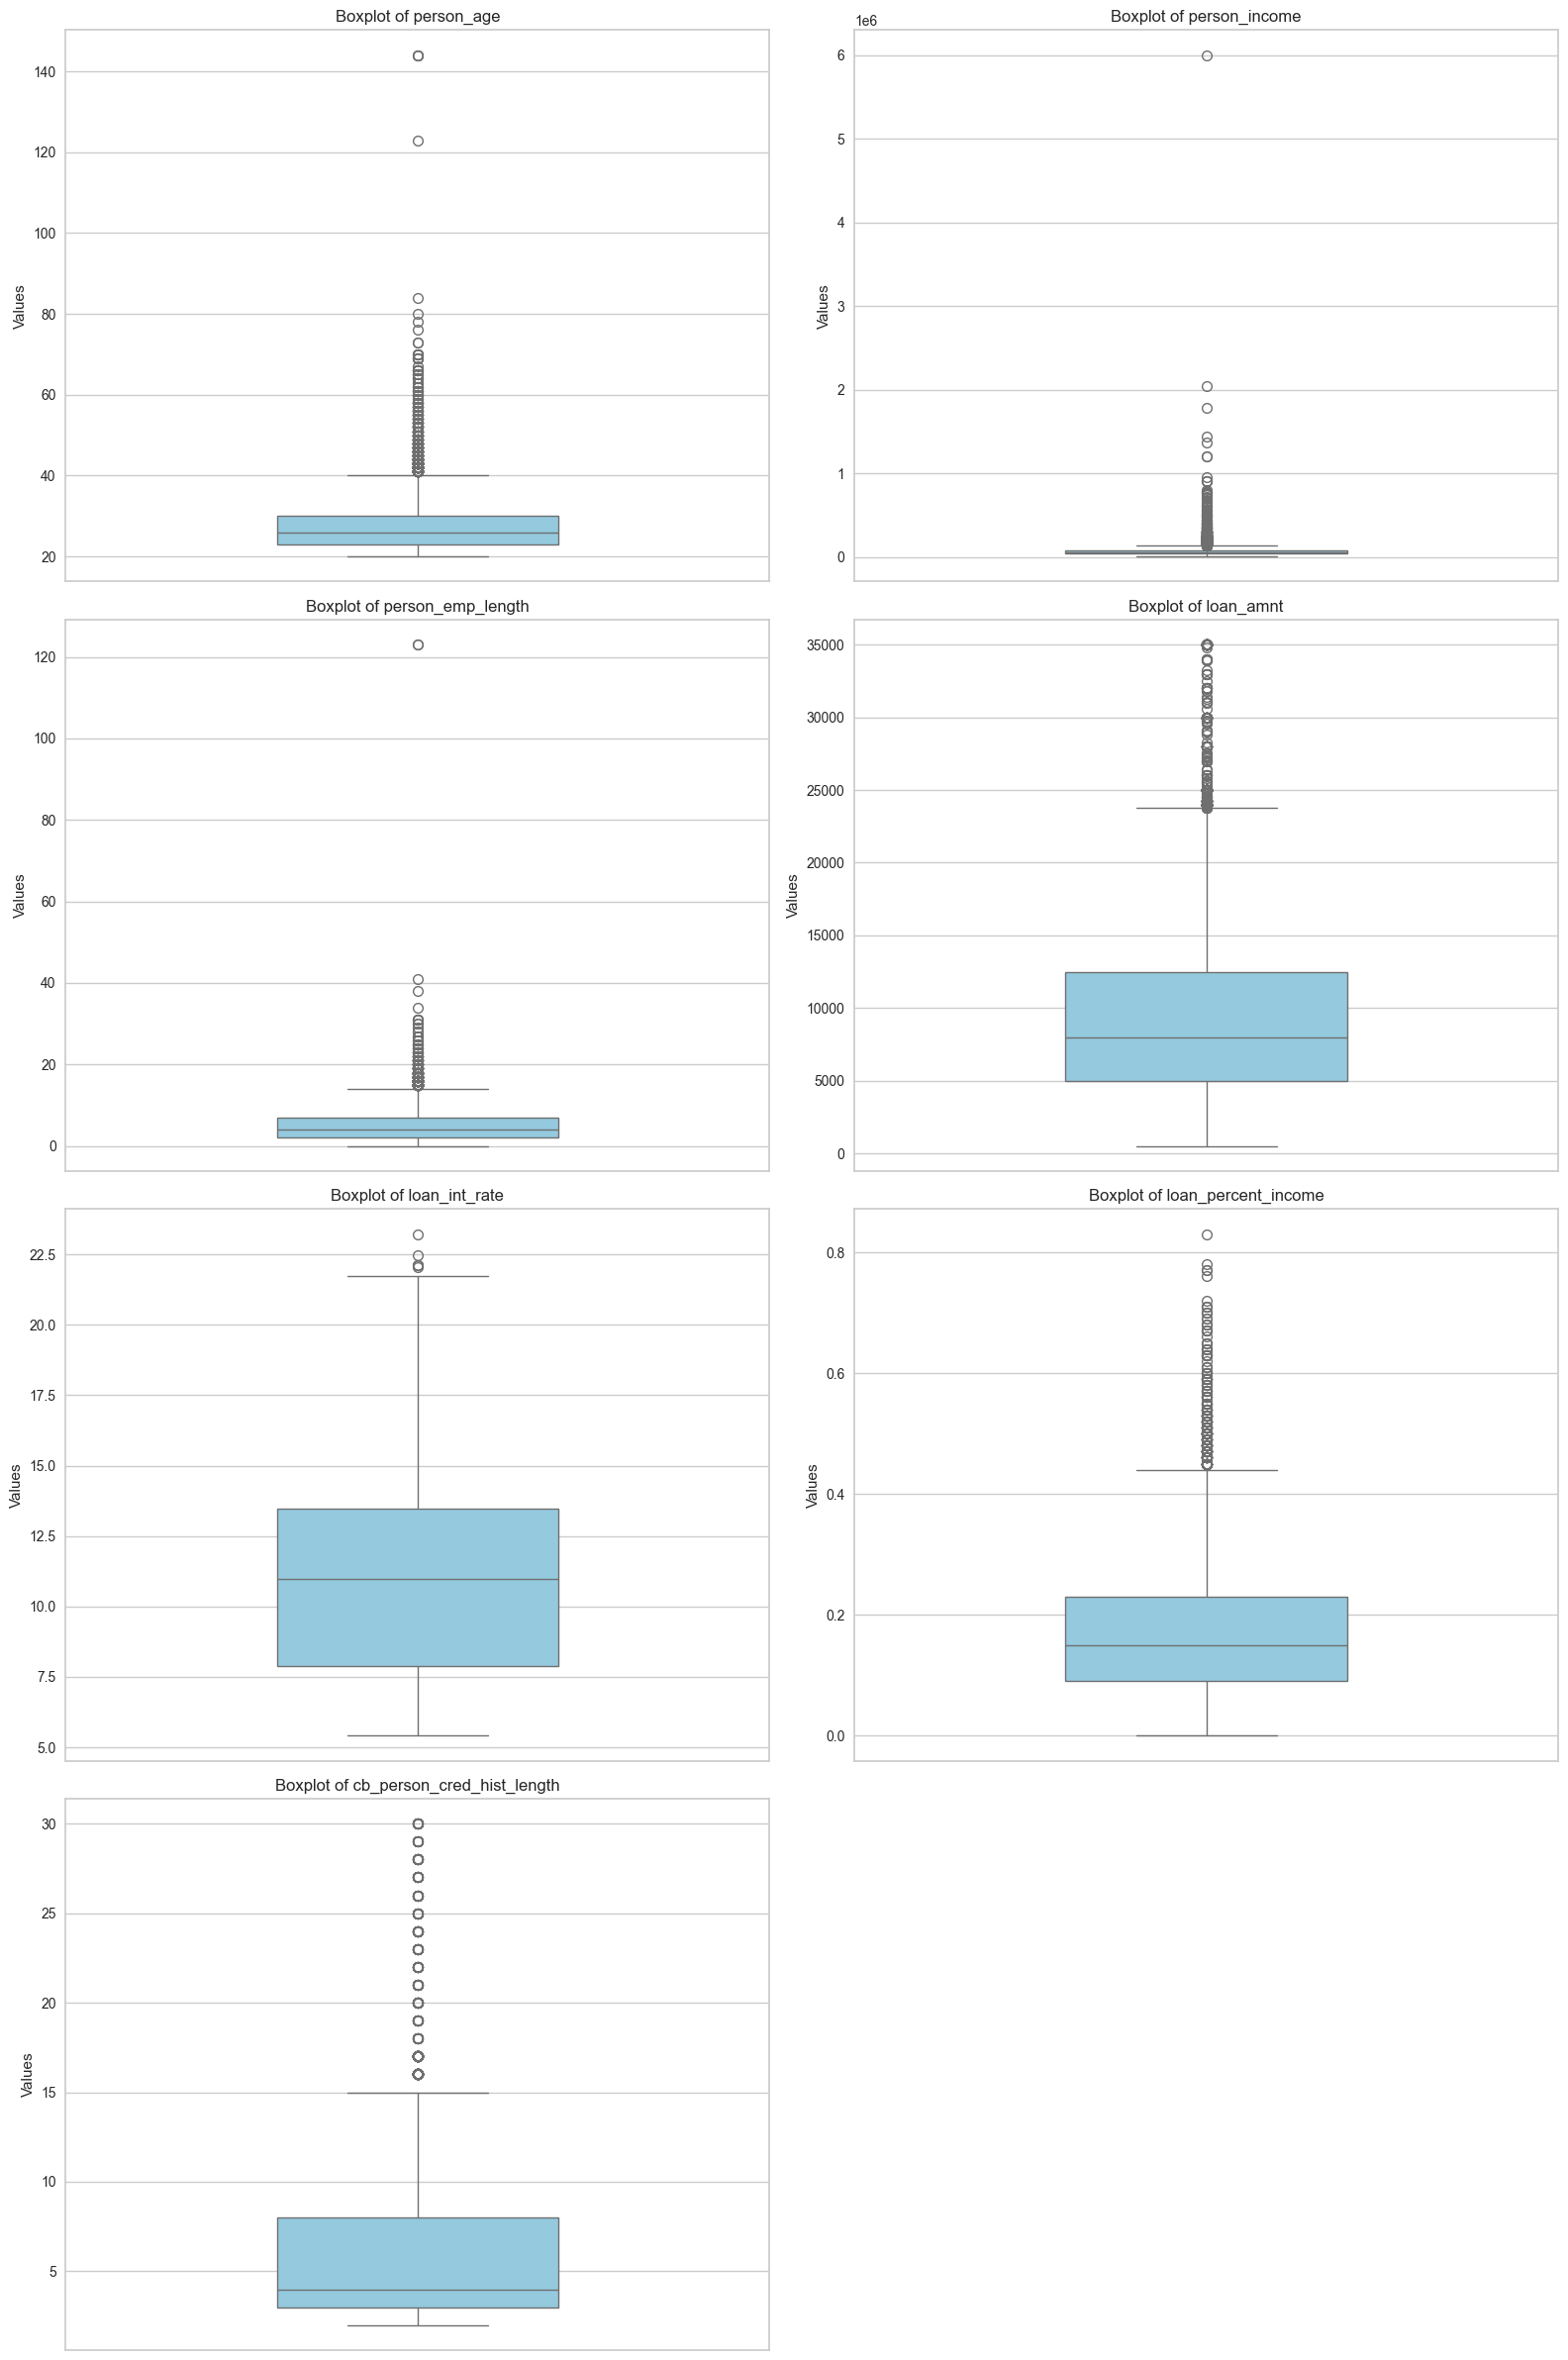

In [26]:
plot_box(credit_df)

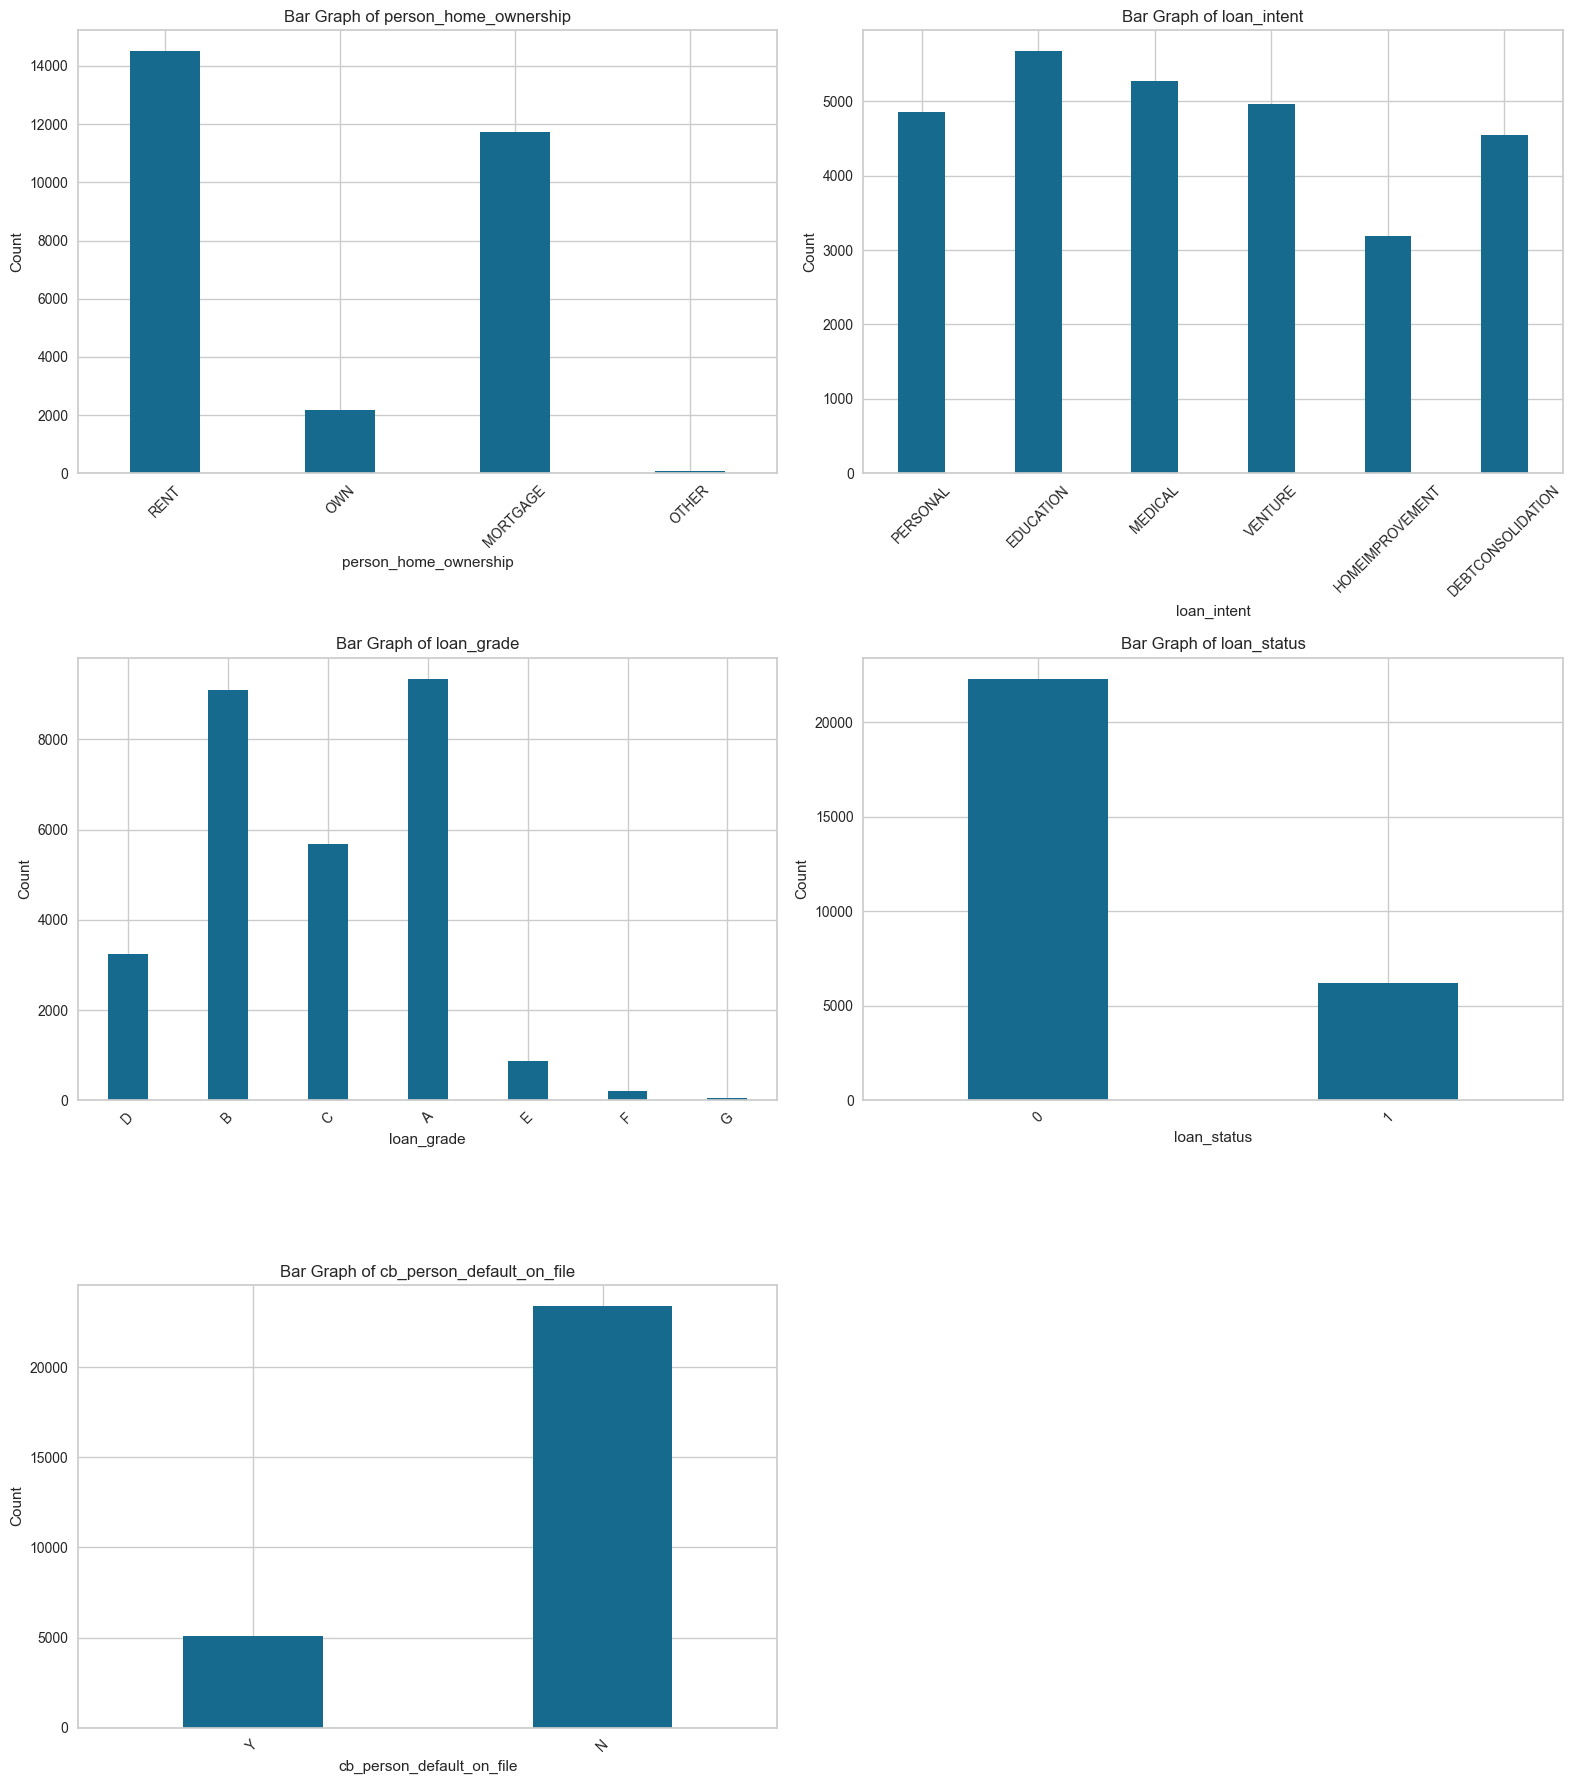

In [27]:
plot_categorical(credit_df)


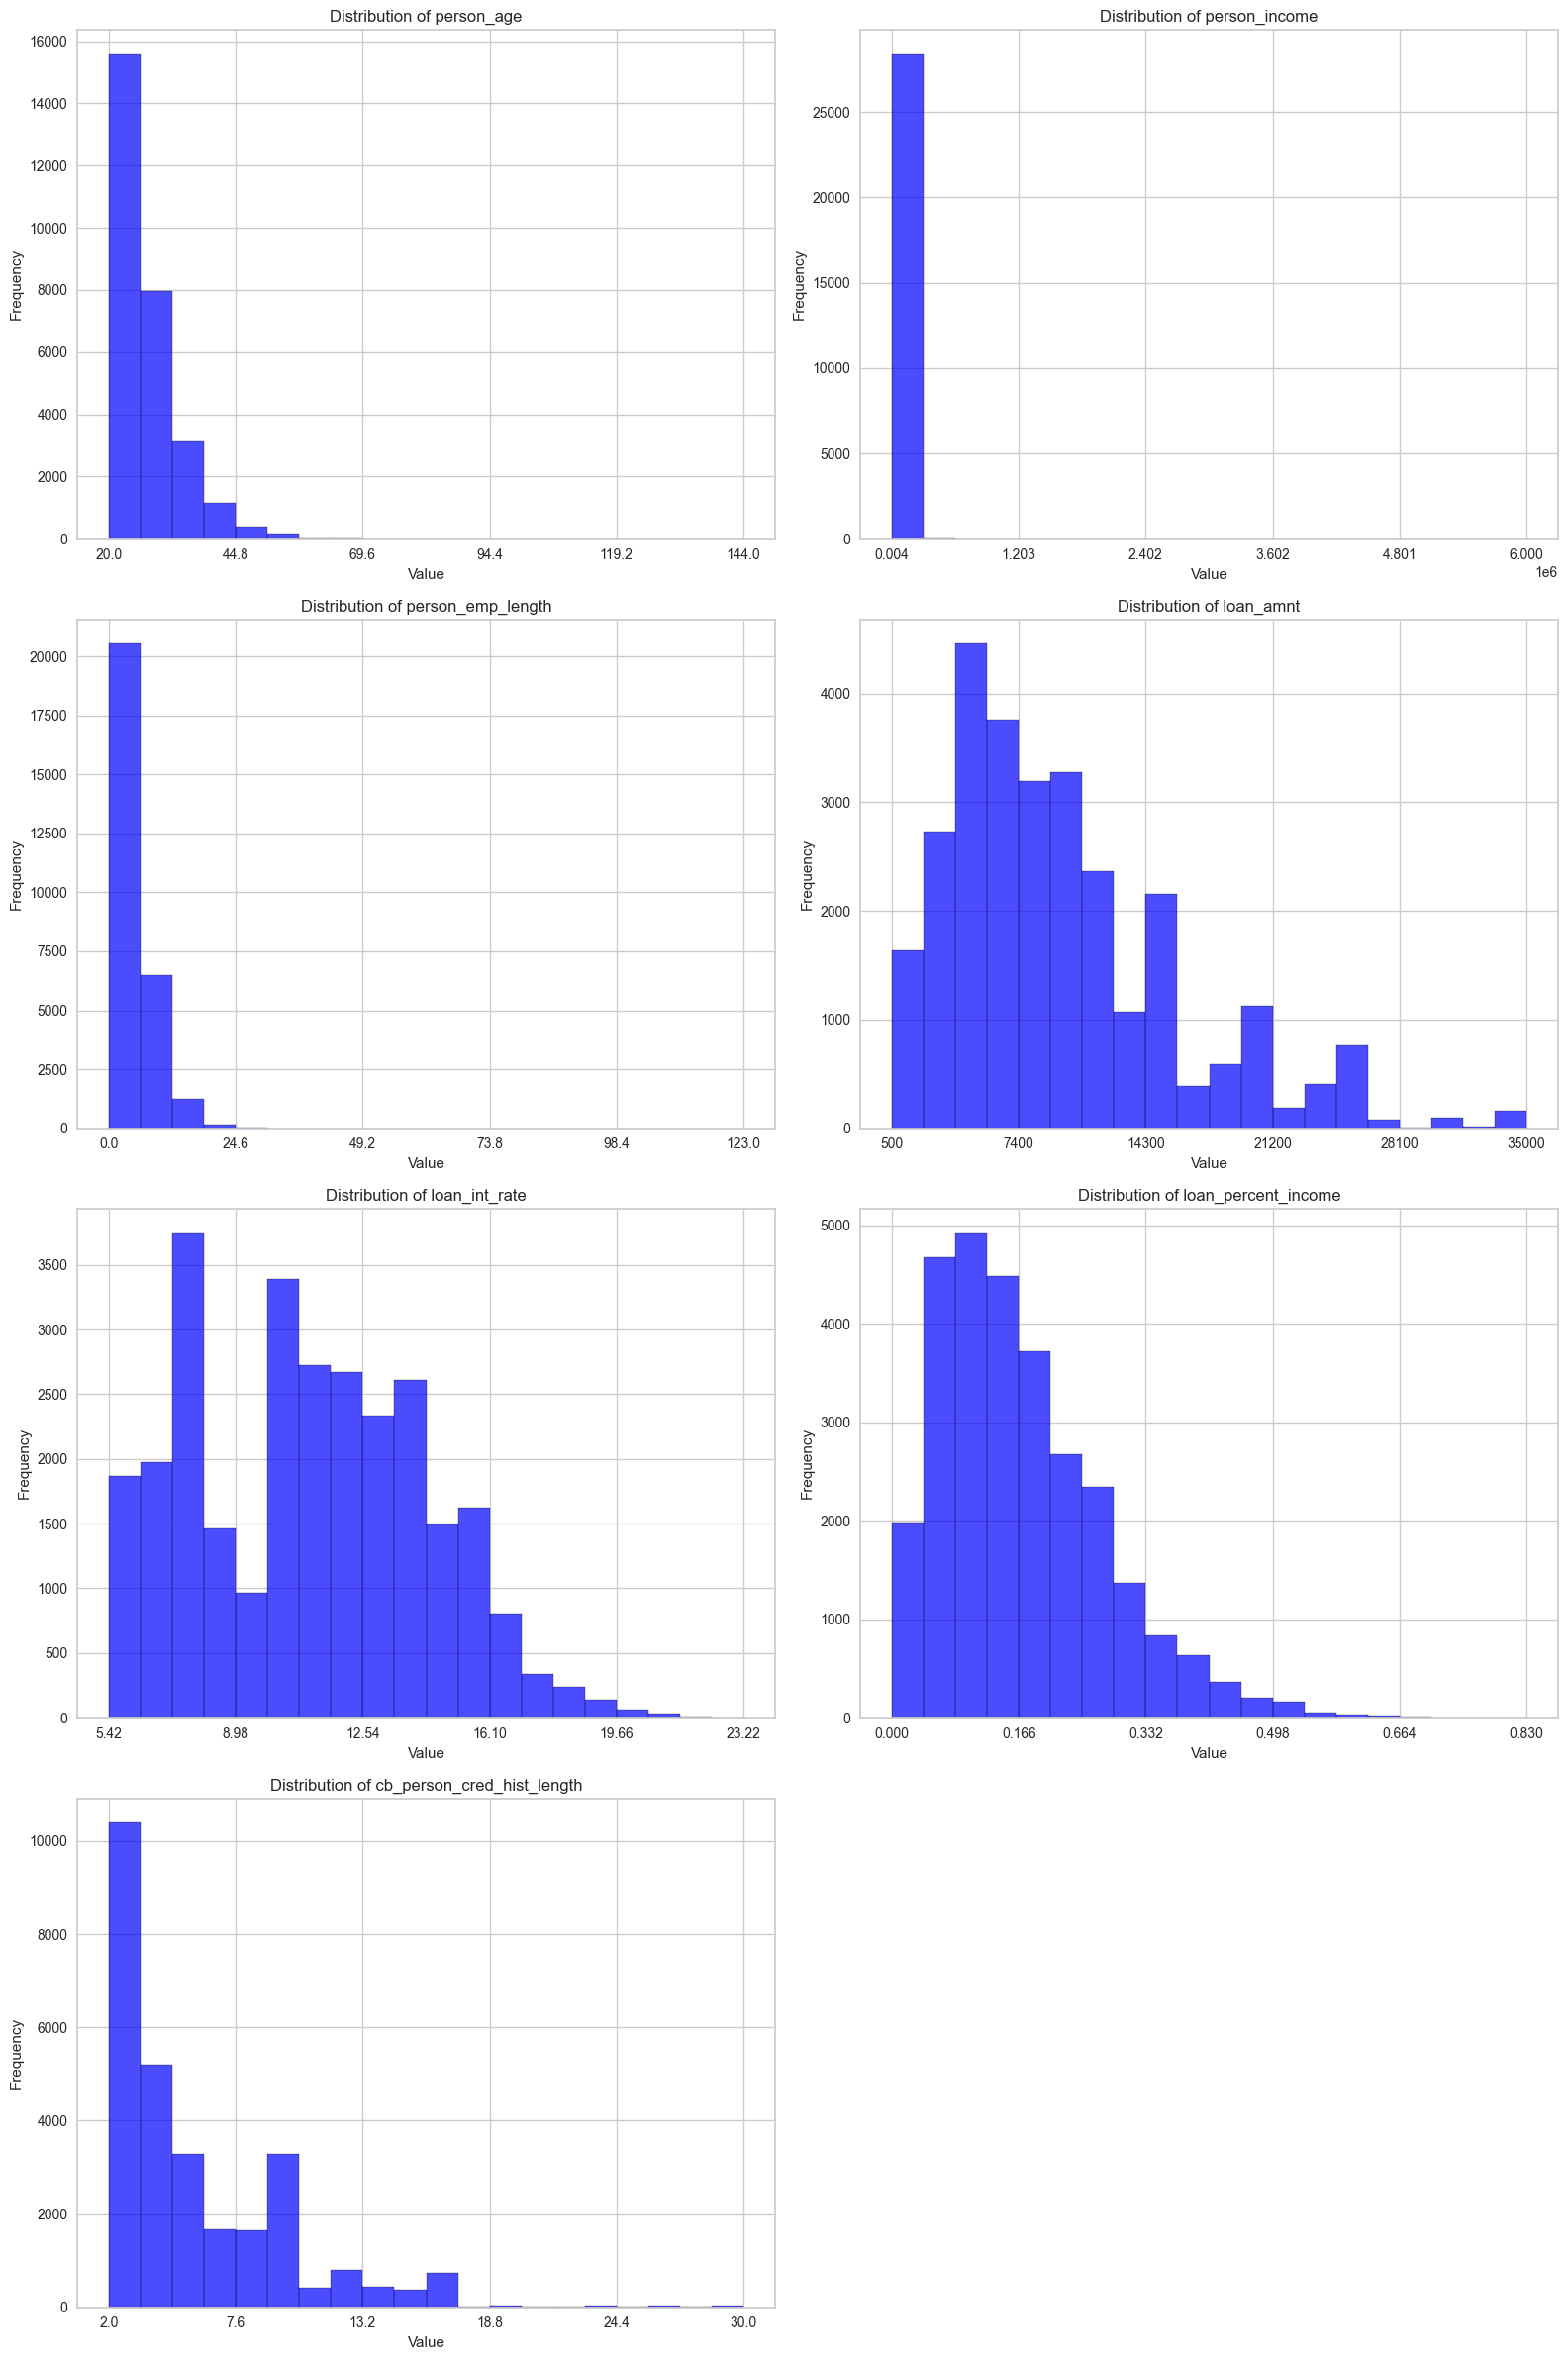

In [28]:
plot_numerical(credit_df)

**Observations:**
- The distributions are skewed
- People under 30 take loans more times than those above thirty
- The majority of loan takers have an income of at most 25000.
- As people spend more time in employment, their tendency to take loans decreases
- Most loans taken are of an amount at most 25 percent of the loanee's income.

### 1. Does the duration of a borrower's credit history have any influence on their loan repayment behavior?

In [29]:
# Make the two categories
defaulted = credit_df['cb_person_cred_hist_length'][credit_df['loan_status']== 1]
paid = credit_df['cb_person_cred_hist_length'][credit_df['loan_status']== 0]
defaulted.shape
paid.shape

(22313,)

### 1. Does the duration of a borrower's credit history have any influence on their loan repayment behavior?

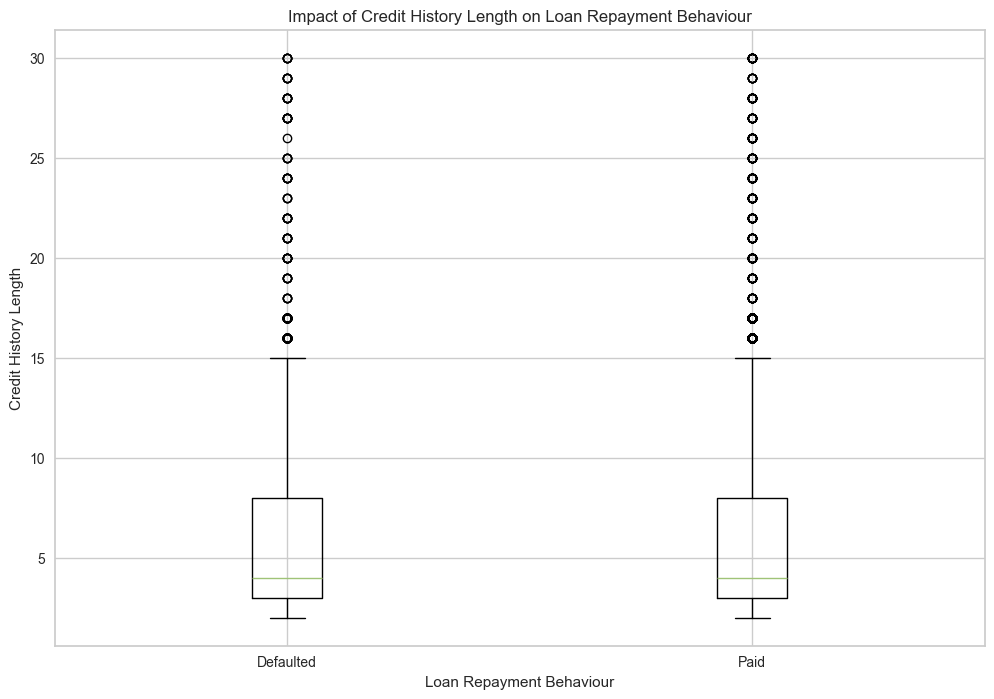

In [30]:
# Box Plot to visualize the relationship
plt.figure(figsize=(12,8))
plt.boxplot([defaulted,paid],
            labels = ['Defaulted', 'Paid']
           )
plt.xlabel('Loan Repayment Behaviour')
plt.ylabel('Credit History Length')
plt.title('Impact of Credit History Length on Loan Repayment Behaviour')
plt.show();


**Observation:**
- There is no observable difference

#### Perform T-Test

##### Confirm equality of variance
**<i>H<sub>o</sub></i>** : There variances are equal  
**<i>H<sub>a</sub></i>** : Variances are not equal   
**$\alpha$** = 0.05

In [31]:
from scipy.stats import levene
_, p_value = levene(defaulted, paid, center = "mean")
print(f"P-Value: {p_value:4f}")

P-Value: 0.841908


- P-value greater than 0.05 means the null hypothesis is accepted. The variances are equal.

##### The T-Test
**H<sub><i>o</i></sub>** : Credit History length has no impact on loan repayment behaviour  
**H<sub><i>a</i></sub>** : Credit History length influences loan repayment behaviour  
**$\alpha$** = 0.05

In [32]:
from scipy.stats import ttest_ind

# The T-Test
t_stat, p_value = ttest_ind(defaulted, paid, equal_var=True)

# Print the t-statistic and p-value
print(f"T-Statistic: {t_stat:4f}")
print(f"P-Value: {p_value:4f}")

T-Statistic: -2.795789
P-Value: 0.005181


**Conclusion:**
- A pvalue less than our alpha value means we reject the null hypothesis and accept the alternate hypothesis.
- Thus, credit history length influences loan repayment behaviour.
- A pearsonr correlation test will be used to identify whether the relationship is statistically significant

#### Pearsonr to Identify nature of relationship

**<i>H<sub>o</sub></i>** : There is no statistically significant relationship between credit history length and loan repayment history  
**<i>H<sub>a</sub></i>** : There is a statistically significant relationship between credit history length and loan repayment history   
**$\alpha$** = 0.05

In [33]:
## Pearsonr requires the two arrays to be equal shape
## Thus, paid is downsampled to match the size of defaulted
# Set the random seed for reproducibility
np.random.seed(42)

# Determine the size of the downsampled paid array
downsample_size = len(defaulted)

# Randomly select observations from defaulted to create the downsampled array
downsampled_paid = np.random.choice(paid, size=downsample_size, replace=False)

In [34]:
from scipy.stats import pearsonr
# Pearsonr correlation test
correlation, p_value = pearsonr(defaulted, downsampled_paid)

# Print the correlation coefficient and p-value
print(f"Correlation Coefficient: {correlation:4f}")
print(f"P-Value: {p_value:4f}")

Correlation Coefficient: -0.002808
P-Value: 0.825211


**Conclusion:**
- A p-value of 0.719, greater than 0.05, means that we fail to reject our null hypothesis and conclude that there is not enough evidence to conclude a significant relationship between the credit history length and loan repayment history
- The correlation coefficient of 0.004268 indicates a weak positive correlation, but it is not statistically significant.
- Based on the previous t-test, we identify the presence of a relationship thought the pearson correlation test concludes that this relationship is not statistically significant

### 2. How does the loan grade assigned by the lending institution impact the interest rates offered to borrowers?

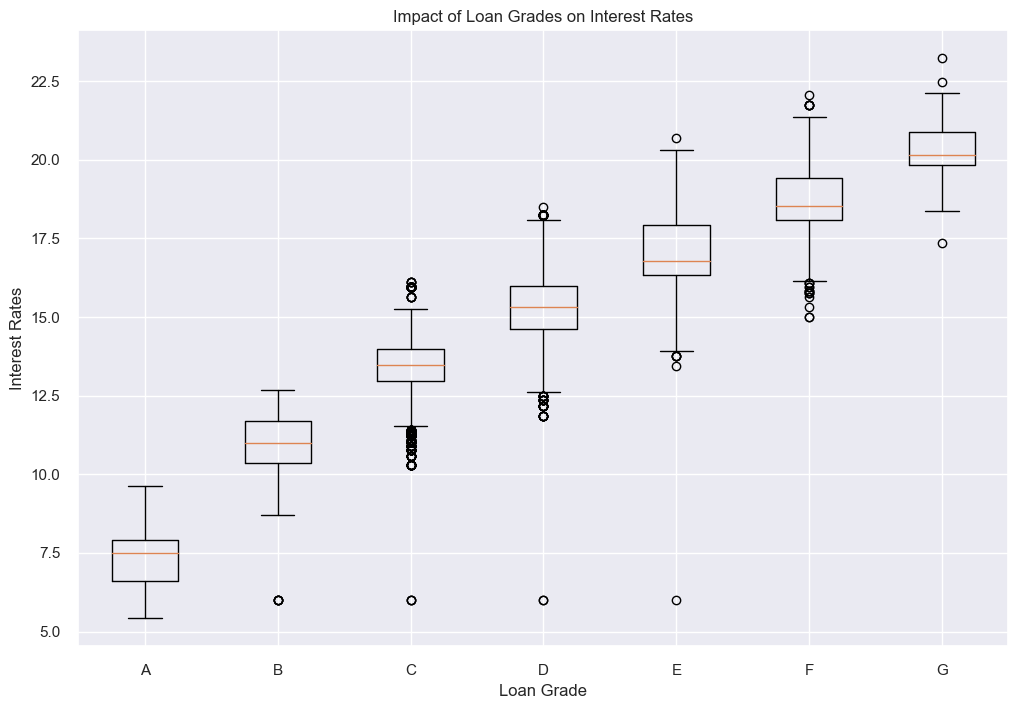

In [115]:
# A boxplot is used for visulization 
## because it provides more information that will be useful for comparison

# Make the categories
loan_grades = sorted(credit_df['loan_grade'].unique())

categories = []
for cat in loan_grades:
    cat = credit_df[credit_df['loan_grade'] == cat]['loan_int_rate']
    categories.append(cat)

# The boxplot
plt.figure(figsize=(12,8))
plt.boxplot(categories, labels = loan_grades)
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rates')
plt.title('Impact of Loan Grades on Interest Rates')
plt.show();

**Observation:**
- It is observable that the loan grade A has the most favourable rates while G has the least favourable rates
- The average interest rates increase with an increase in loan grade from A to G
- The means are clearly different, thus there is no need for ANOVA. 

### 3. Are there notable differences in the loan amounts requested by borrowers, based on their home ownership status?

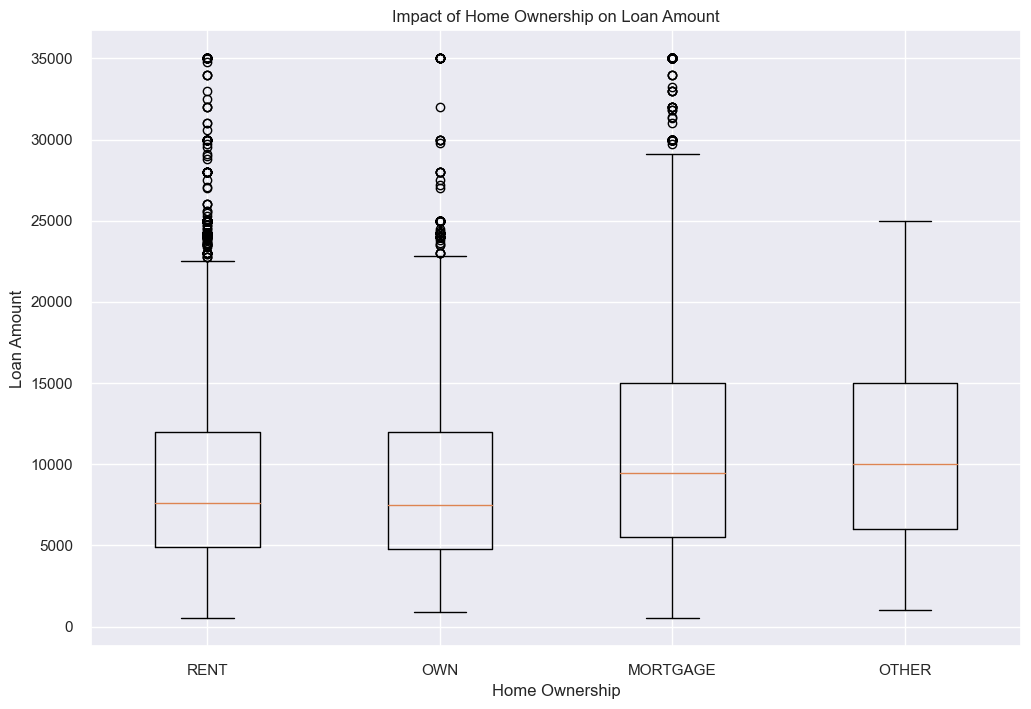

In [116]:
# A boxplot is used for visulization 
## because it provides more information that will be useful for comparison

# Make the categories
home_ownership = credit_df['person_home_ownership'].unique()

categories = []
for cat in home_ownership:
    cat = credit_df[credit_df['person_home_ownership'] == cat]['loan_amnt']
    categories.append(cat)

# The boxplot
plt.figure(figsize=(12,8))
plt.boxplot(categories, labels = home_ownership)
plt.xlabel('Home Ownership')
plt.ylabel('Loan Amount')
plt.title('Impact of Home Ownership on Loan Amount')
plt.show();

**Observation:**
- Other category has the highest average loan amount requested followed by mortgage
- The difference in means portrays a difference in the loan amounts requested by borrowers
- OLS regression will be used to confirm what the boxplot portrays

#### Regression

**<i>H<sub>o</sub></i>** : There is no difference in the loan amounts requested by borrowers, based on their home ownership status   
**<i>H<sub>a</sub></i>** : There is a difference in the loan amounts requested by borrowers, based on their home ownership status   
**$\alpha$** = 0.05

In [117]:
import statsmodels.api as sm
x = pd.get_dummies(credit_df['person_home_ownership'])
y = credit_df['loan_amnt']
X = sm.add_constant(x)
model = sm.OLS(y,x).fit()
y_pred = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              loan_amnt   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     167.3
Date:                Sun, 24 Dec 2023   Prob (F-statistic):          1.58e-107
Time:                        19:59:16   Log-Likelihood:            -2.8966e+05
No. Observations:               28501   AIC:                         5.793e+05
Df Residuals:                   28497   BIC:                         5.794e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MORTGAGE    1.064e+04     57.923    183.719      0.000    1.05e+04    1.08e+04
OTHER       1.108e+04    650.678     17.023      0.000    9801.253    1.24e+04
OWN         9129.1973    134.579     67.835      0.000    8865.416    9392.979
RENT        8933.1270     52.114    171.415      0.000    8830.981    9035.273
==============================================================================
Omnibus:                     4907.244   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8257.117
Skew:                           1.146   Prob(JB):                         0.00
Kurtosis:                       4.303   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- As we are comparing the mean values of multiple categories, we've used OLS in place of ANOVA
- As such, we focus on F-Statistics and p-value `Prob (F-statistic)` in upper table, and coef in the second table

**Conclusion:**
- A p-value less than 0.05 means we reject the null hypothesis and accept the alternate hypothesis
- As such, there is a notable difference in the loan amounts requested by borrowers, based on their home ownership status
- The coefficients(coef) point out that OTHER has the highest coefficient, followed by MORTGAGE, OWN and RENT respectively.
- We can conclude that those who RENT take lower amounts, followed by OWN and MORTGAGE, while those who have OTHER as their home ownership category take larger amounts for their loan.

### 4. What is the average percentage of a borrower's income dedicated to loan repayment in different loan intent categories?

In [118]:
credit_df['loan_intent'].value_counts()

loan_intent
EDUCATION            5670
MEDICAL              5269
VENTURE              4969
PERSONAL             4859
DEBTCONSOLIDATION    4547
HOMEIMPROVEMENT      3187
Name: count, dtype: int64

In [119]:
# Get the unique loan intent categories in an array
loan_intent_categories = credit_df['loan_intent'].unique()

print("Average percentage of a borrower's income dedicated to loan repayment in different loan intent categories.")

# Iterate over the loan intent categories and print each percentage
for cat in loan_intent_categories:
    average = (credit_df[credit_df['loan_intent'] == cat]['loan_percent_income']).mean()
    print(f'Average Percentage of Income for {cat} is: {average:.4f}' )

Average percentage of a borrower's income dedicated to loan repayment in different loan intent categories.
Average Percentage of Income for PERSONAL is: 0.1687
Average Percentage of Income for EDUCATION is: 0.1692
Average Percentage of Income for MEDICAL is: 0.1730
Average Percentage of Income for VENTURE is: 0.1695
Average Percentage of Income for HOMEIMPROVEMENT is: 0.1637
Average Percentage of Income for DEBTCONSOLIDATION is: 0.1707


## Further Inspection of Data before creating Predictive Models

In [120]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(credit_df)

Observations: 28501
Variables: 12
cat_cols: 5
num_cols: 7
cat_but_car: 0
num_but_cat: 1


## View Correlations of Variables in Dataset

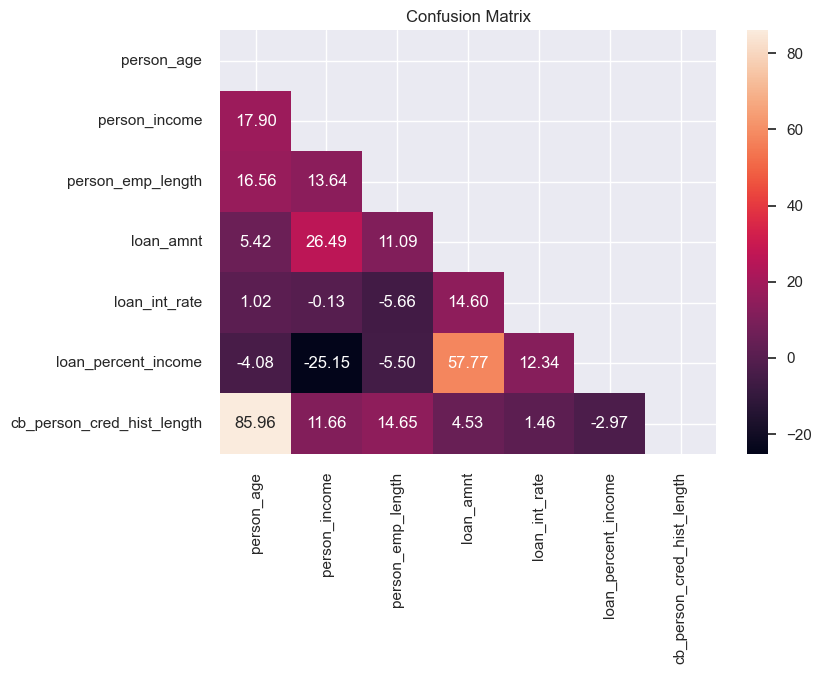

['cb_person_cred_hist_length']

In [121]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Select only the numeric columns from the DataFrame
    numeric_dataframe = dataframe.select_dtypes(include=['number'])
    
    corr = numeric_dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    
    if plot:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr * 100, annot= True, fmt='.2f', mask=mask)
        plt.title('Confusion Matrix')
        plt.show()
    
    return drop_list

# Usage example:
high_correlated_cols(credit_df, plot=True)

## Check for Outliers

In [122]:
# Convert loan_status back to numeric
credit_df['loan_status'] = pd.to_numeric(credit_df['loan_status'], errors='coerce')

def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    if col != "loan_status":
      print(col, check_outlier(credit_df, col))

person_age True
person_income True
person_emp_length True
loan_amnt False
loan_int_rate False
loan_percent_income True
cb_person_cred_hist_length True


In [123]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "loan_status":
        replace_with_thresholds(credit_df,col)

In [124]:
credit_df['income_group'] = pd.cut(credit_df['person_income'],
                              bins=[0, 25000, 50000, 75000, 100000, float('inf')],
                              labels=['low', 'low-middle', 'middle', 'high-middle', 'high'])

In [125]:
dfx=credit_df.copy()
cat_cols, cat_but_car, num_cols = grab_col_names(dfx)
cat_cols.remove("loan_status")


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first,dtype=int)
    return dataframe

dfx = one_hot_encoder(dfx, cat_cols, drop_first=True)

X = dfx.drop(['loan_status',"person_age","person_income"], axis=1)
y = dfx['loan_status']

pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X = pipeline.fit_transform(X)
X.shape

smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)
print("Final dimensions of target label classes:", Counter(y))

Observations: 28501
Variables: 13
cat_cols: 6
num_cols: 7
cat_but_car: 0
num_but_cat: 2
Final dimensions of target label classes: Counter({1: 22313, 0: 22313})


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4463
           1       0.98      0.92      0.95      4463

    accuracy                           0.95      8926
   macro avg       0.95      0.95      0.95      8926
weighted avg       0.95      0.95      0.95      8926

--------------------------------------------------


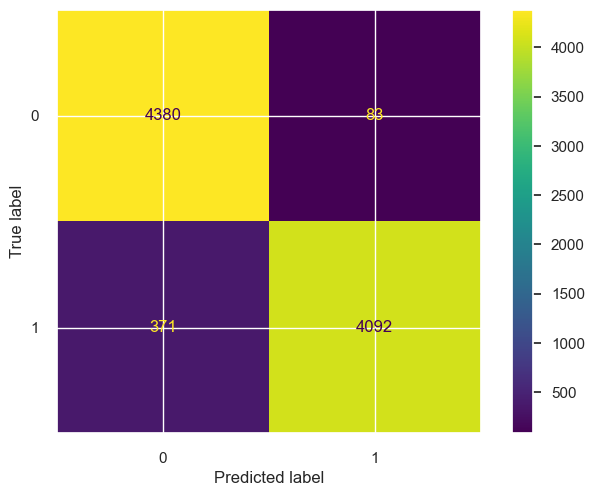

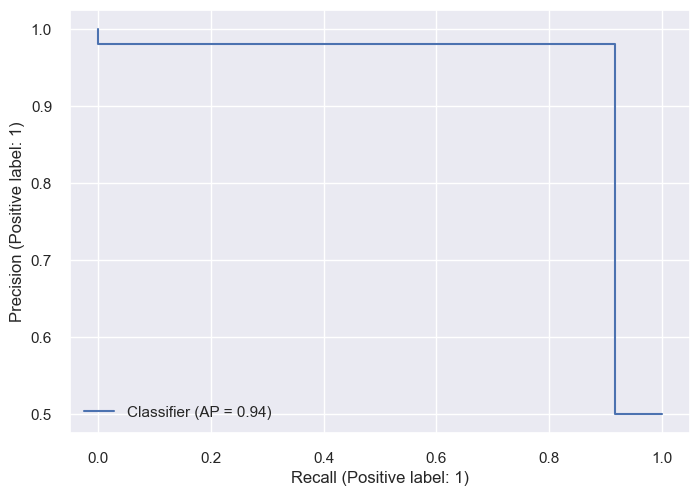

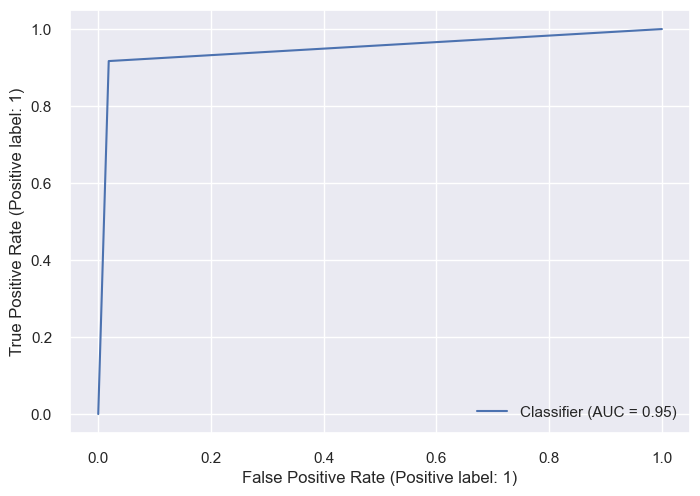

In [129]:
import re
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
#scaling variables
scaler = StandardScaler()
#scaler= RobustScaler()
scaled_train_X = scaler.fit_transform(X_train)
scaled_test_X = scaler.transform(X_test)

def train_and_evaluate_model(model):
    model.fit(scaled_train_X,y_train)
    y_pred = model.predict(scaled_test_X)
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    PrecisionRecallDisplay.from_predictions(y_test,y_pred)
    RocCurveDisplay.from_predictions(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    roc_auc = roc_auc_score(y_test,y_pred,average='macro')
    
    if re.search('catboost',str(model)) == None:
        visualizer = ClassPredictionError(model)
        visualizer.score(scaled_test_X,y_test)
        visualizer.show()
        del visualizer
        
    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)
    del acc, precision, recall, f1, roc_auc
    gc.collect()
train_and_evaluate_model(CatBoostClassifier(silent=True))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4441
           1       0.97      0.72      0.82      1260

    accuracy                           0.93      5701
   macro avg       0.95      0.86      0.89      5701
weighted avg       0.93      0.93      0.93      5701

--------------------------------------------------


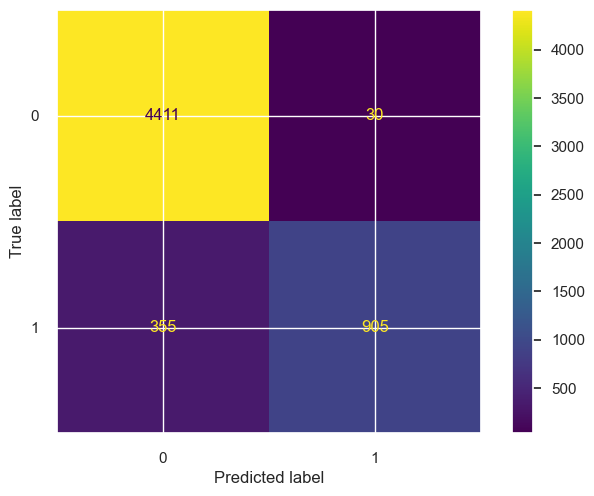

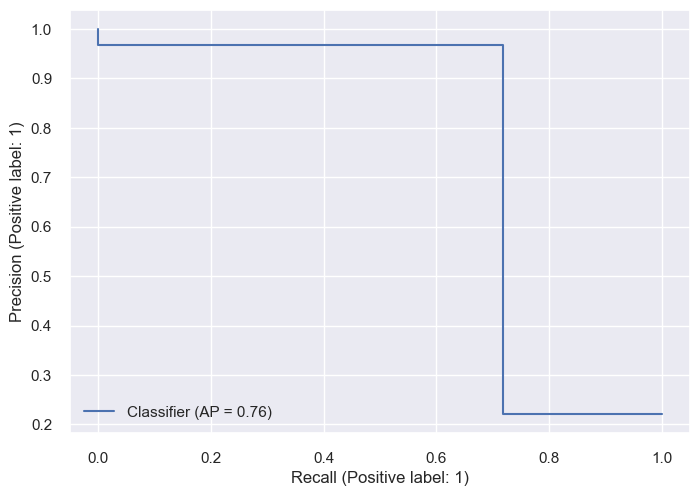

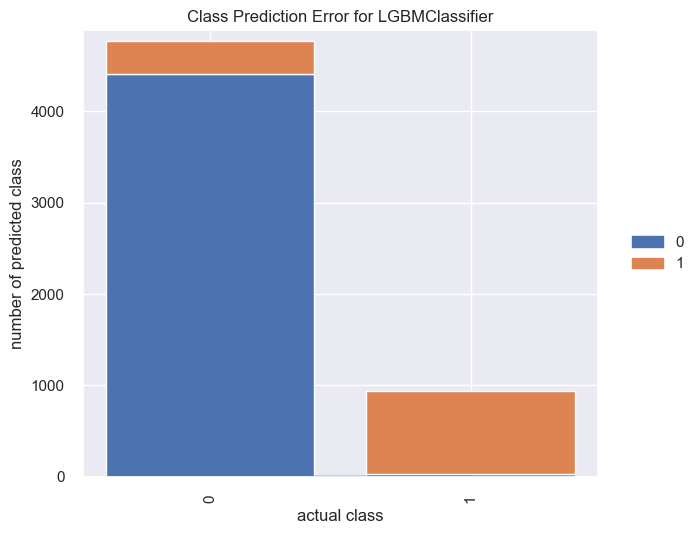

In [127]:
train_and_evaluate_model(LGBMClassifier(verbose=-1))

In [128]:
from sklearn.ensemble import RandomForestClassifier
train_and_evaluate_model(RandomForestClassifier())

KeyboardInterrupt: 

In [ ]:
train_and_evaluate_model(XGBClassifier())

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier

train_and_evaluate_model(StackingClassifier(estimators=[
    ('ET',ExtraTreesClassifier()),
    ('XGB',XGBClassifier()),
    ('CAT',CatBoostClassifier(silent=True))
],final_estimator=RandomForestClassifier(),verbose=2))

In [ ]:
model_perfs = pd.DataFrame({'Model': models, 
                            'Accuracy': accuracy_scores, 
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs

# Conclusion
1. **Accuracy:** The models, including CatBoostClassifier and LGBMClassifier, demonstrate relatively high accuracy, ranging from 92.8% to 93.4%. This suggests that the models are effective in making correct overall predictions on the credit risk dataset.
2. **Precision and Recall:** Precision and recall metrics provide insights into the model's ability to make accurate positive predictions and capture true positive instances. The models exhibit a balance between precision and recall, with values ranging from 85.8% to 94.6%. This balance is crucial in credit risk evaluation, as both false positives and false negatives have significant implications.
3. **F1 Score:** The F1 score, which is the harmonic mean of precision and recall, also reflects the models' balanced performance. F1 scores range from 88.5% to 89.2%, reinforcing the notion that the models achieve a good trade-off between precision and recall.

4. The machine learning models, particularly the StackingClassifier, CatBoostClassifier, and LGBMClassifier, demonstrate strong performance in evaluating credit risk. 
The balanced nature of these models, as reflected in precision, recall, and F1 score metrics, positions them well for real-world applications where both false positives and false negatives have significant consequences. 